<div align="center">
  <h1>Predictions using Bayesian Models</h1>
  <br>
  <b>Lyla Fadden, Filip Piasevoli, Aaron Zampaglione</b>
  <br>
  <i>Pavlos Protopapas</i>
  <br>
  https://github.com/azampagl/gp-and-bayesian-predictions
  <br>
  http://azampagl.github.io/gp-and-bayesian-predictions/
</div>

*****

## Background/Motivation ##
We are members of a four-person team of Harvard students working alongside MBTA staff to analyze and better predict demand for public transportation. The primary goal of that project is a machine learning model to predict subway demand, accounting for recent past ridership, seasonal/cyclical effects, and sporadic events like severe weather and major events. 

### Problem Definition ###

We’ve built predictive models for MBTA ridership as part of our Capstone project, but even with two years worth of data, we’ve run into several problems when building models.





One model looks to predict the change in ridership for a particular station as a function of the amount of snowfall. Snowfall, however, occurs in greater frequency for amounts of 0-3 inches than it does for greater amounts of snow like 6-10 inches. Further, there seems to be much more noise in ridership for days with low amounts of snow, possibly due to inaccurate forecasts, school closings, service delays, or other extraneous factors. A simple linear model seems too rigid and does not do a good job of imputing values for unobserved amounts of snowfall. We hope to use Gaussian Processes to better model the effect of snowfall on ridership as it considers the span of all gaussian fits constrained by the relatively low amount of days we do observe with snow.

Secondly, we look to predict the general ridership of a station on any particular day as a function of historical ridership as well as other external factors like the weather or public events. Currently, we use the predictors to build a linear model, but it suffers from overfitting to station closures, holidays, and general outliers. We hope to use both Gaussian Processes and Bayesian Linear regression to create two alternative models to which we can compare our simple linear model fit by OLS.

### Questions to Address ###

- Can we improve prediction results by using Bayesian Linear Regression vs. OLS Regression?

### Methodology ###

- We will use a Bayesian Linear Regression framework, similar to the last problem in HW7, in order to estimate the parameters of the linear models to predict ridership.

### Data ###

- We have two years worth of MBTA entries data aggregated at 15-minute intervals for each station.
- We also have the amount of snowfall data from NOAA for each day appearing in the aforementioned data set.
- We have the important public events (Red Sox, Celtics, and Bruins game) for each day appearing in the aforementioned data set.

## Bayesian Linear Prediction ##

In [2]:
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pymc

import sklearn
from sklearn import cross_validation, grid_search
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

### Load Data ###

In [3]:
data = pd.read_csv('../data/mbta_daily_weather_games_grouping_noholidays_weekdays.csv', low_memory=False).reset_index(drop=True)
data.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,stationid,grouping,grouping_sum_weeks_ago_1
0,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-03 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
1,1002,2013-01-04 00:00:00,6125,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-04 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781
2,1002,2013-01-07 00:00:00,5998,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-07 04:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
3,1002,2013-01-08 00:00:00,6002,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-08 04:30:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
4,1002,2013-01-09 00:00:00,6055,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-09 04:45:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781


#### Optimal Features ####

The optimal features used for prediction were determined from a previous experiment. Some of the feature include:

- ***entries_weeks_ago_1***: The number of entries for this station on the same day one week ago.
- ***snow_fall***: The amount of snow the fell for that day, in inches.
- ***snow_accum***: The amount of snow accumulated up to the current day. The snow accumulation was calculated using a quasi-linear decay function based on the snow fall of the previous two weeks.
- ***bruins_game***: Binary column representing if a Bruins game occurred on this day.
- ***celtics_game***: Binary column representing if a Celtics game occurred on this day.
- ***sox_game***: Binary column representing if a Red Sox game occurred on this day.

In [4]:
features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1']

#### Helper Methods ####

In [5]:
"""
Returns the necessary training data for a particular station.

Key arguments:
station -- The station to get the data for.
"""
def station_data(station):
    # Only look at rows in which we have values.
    ix = (pd.notnull(station['entries_weeks_ago_1']).values) & \
         (pd.notnull(station['entries_weeks_ago_2']).values) & \
         (pd.notnull(station['entries_weeks_ago_3']).values)
            
    Y = station[ix]['entries'].values
    X = station[ix][features].values
    
    return Y, X

In [6]:
"""
Compares a data set using ordinary linear regression and bayesian linear regression.

Key arguments:
Y      -- The outcome variable.
X      -- The predictors (features).
beta   -- The betas from the bayesian MCMC sampling.
rstate -- The random state to use.
"""
def compare(Y, X, betas, rstate):
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=rstate)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(linear_model.LinearRegression(), {}, scoring='mean_squared_error', cv=10)
    clf.fit(x_train, y_train)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    y_pred_lsr = model.predict(x_test)
    error_lsr = np.sum(np.abs(y_pred_lsr - y_test)) / np.sum(y_test)
    
    y_pred_blr = np.array([np.sum(betas * x_test[i]) for i in xrange(len(x_test))])
    error_bsr = np.sum(np.abs(y_pred_blr - y_test)) / np.sum(y_test)
    
    return error_lsr, error_bsr

### Determine Priors ###

In order to sample from a bayesian posterior, we need to generate priors for each of our parameters (features). The priors can be uninformative or informative. In our case, we can approximate the true values using linear regression. The coefficients generated using linear regression will act as the $mu$ for normal priors for each feature. (Even though we can approximate the true values, we're going to keep our variance relatively high.)

In [27]:
# The variances for each normal distribution for each feature.
prior_vars = {
    'entries_weeks_ago_1': 10.0,
    'entries_weeks_ago_2': 10.0,
    'entries_weeks_ago_3': 10.0,
    'month_1': 10000.0,
    'month_2': 10000.0,
    'month_3': 10000.0,
    'month_4': 10000.0,
    'month_5': 10000.0,
    'month_6': 10000.0,
    'month_7': 10000.0,
    'month_8': 10000.0,
    'month_9': 10000.0,
    'month_10': 10000.0,
    'month_11': 10000.0,
    'month_12': 10000.0,
    'snow': 1000.0,
    'snow_fall': 20000.0,
    'snow_accum': 20000.0,
    'bruins_game': 100000.0,
    'celtics_game': 100000.0,
    'sox_game': 100000.0,
    'grouping_sum_weeks_ago_1': 1000000.0,
}

In [28]:
"""
Determine the coefficients for the entire MBTA system using linear regression.

Key arguments:
Y -- The outcome variable.
X -- The predictors (features).
"""
def system_coefs(Y, X):
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    
    coefs = model.coef_
    results = {}
    for i, feature in enumerate(features):
        results[feature] = coefs[i]
    
    return results

In [29]:
"""
Returns the PyMC priors for the entire MBTA system.

Key arguments:
stations -- All of the stations in the MBTA.
"""
def system_priors(stations):
    
    # Determine all of the outcomes and predictors for the entire system.
    Y = []
    X = []
    for locationid in np.unique(stations.locationid):
        y, x = station_data(stations[stations['locationid'] == locationid])
        Y.extend(y)
        X.extend(x)
    
    coeffs = system_coefs(Y, X)
    
    results = []
    for feature in features:
        results.append(pymc.Normal(feature, mu=coeffs[feature], tau=1.0 / prior_vars[feature]))
    
    return results

### Model Generation ###

In [40]:
"""
Generates a MAP model for a station.

Key arguments:
priors -- The priors of the entire system.
Y      -- The outcome variable.
X      -- The predictors (features).
"""
def station_model(priors, Y, X):
    # Define the pymc method which acts as the regression calculator.
    @pymc.deterministic
    def y_hat(betas=priors, X=X):
        return X.dot(np.array(betas))
    
    # The likelihood model.
    Y_hat = pymc.Normal('Y_hat', mu=y_hat, tau=1.0 / 100.0, value=Y, observed=True)
    
    distributions = [Y_hat] + priors
    
    # Generate the prior models.
    model = pymc.Model(distributions)
    model = pymc.MAP(model)
    model.fit()
    
    return model

In [46]:
"""
Runs an MCMC sampler for a station.

Key arguments:
model -- The MAP model for the station.
"""
def station_mcmc(model):
    
    # The latest pymc tries to sample on the string features. Hopefully this will be fixed in the next release.
    for key in model.__dict__.keys():
        if not isinstance(key, basestring):
            del model.__dict__[key]
            
    mcmc = pymc.MCMC(model)
    mcmc.sample(25000, 10000, 5)
    
    return mcmc

In [47]:
"""
Runs a full bayesian regression on a station and returns the mcmc sampler and the bayesian
coefficients

Key arguments:
priors -- The priors for the entire system.
Y      -- The outcome variable for this station.
X      -- The predictors (features) for this station.
"""
def station_bayesian_regression(priors, Y, X):
    # Get the stations Bayesian model.
    model = station_model(priors, Y, X)
    # Run MCMC on the model.
    mcmc = station_mcmc(model)
    
    # Get the coefficients that were generated from the MCMC.
    coefs = {}
    for feature in features:
        trace = mcmc.trace(feature)[:]
        coefs[feature] = trace.mean()
    
    return mcmc, coefs

### Bayesian Regression on One Station ###

In order to understand the process, lets run bayesian regression on one station and take a look at the MCMC results.

In [48]:
priors = system_priors(data)
harvard = data[data['locationid'] == 1035]
Y, X = station_data(harvard)
mcmc, coefs = station_bayesian_regression(priors, Y, X)

 [-----------------100%-----------------] 25000 of 25000 complete in 44.4 sec

snow_fall: -447.353663288
month_12: -1288.36129828
snow: 78.2268946317
month_10: 444.597372563
month_11: 34.0076063079
month_4: -41.8900211798
month_5: 353.291244706
month_6: -313.828893611
month_7: 297.650741299
month_1: -780.691114163
month_2: 1241.27731458
month_3: 327.559656348
month_8: -799.985697681
month_9: 722.105772393
sox_game: 390.644532409
grouping_sum_weeks_ago_1: 7.69967804572e-05
entries_weeks_ago_2: 0.222235419024
entries_weeks_ago_3: 0.133107411802
snow_accum: -307.480022334
bruins_game: -426.449531603
entries_weeks_ago_1: 0.186582838183
celtics_game: 903.673811806
Plotting bruins_game
Plotting month_6
Plotting month_10
Plotting month_3
Plotting month_2
Plotting entries_weeks_ago_2
Plotting month_1
Plotting month_9
Plotting month_8
Plotting snow_accum
Plotting entries_weeks_ago_1
Plotting celtics_game
Plotting month_7
Plotting month_11
Plotting entries_weeks_ago_3
Plotting month_4
Plotting snow_fall
Plotting month_12
Plotting snow
Plotting sox_game
Plotting month_5
Plo

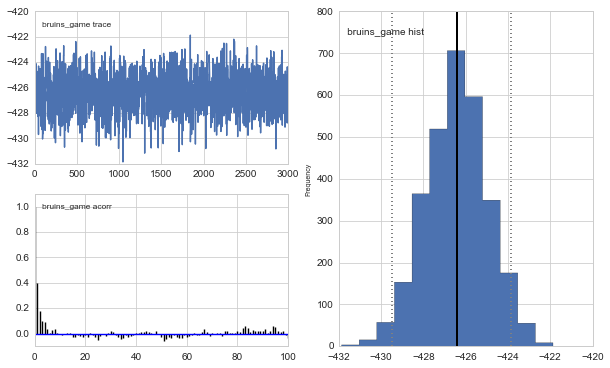

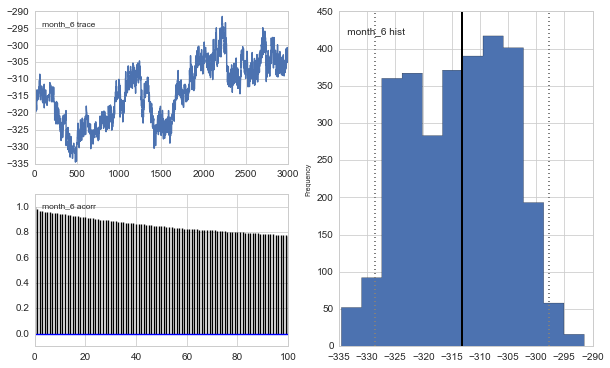

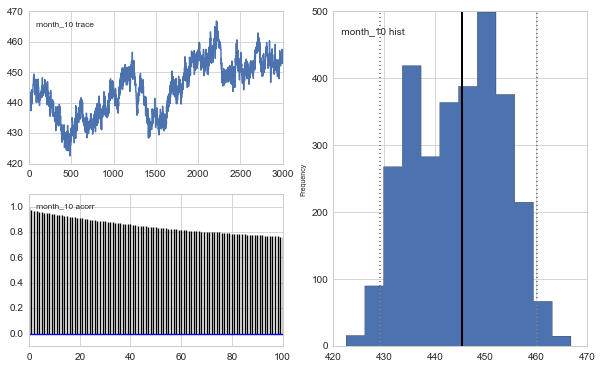

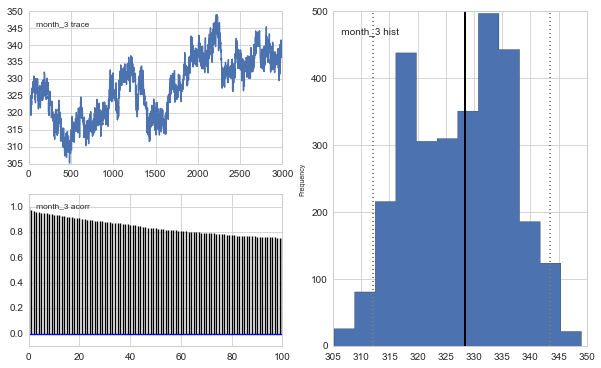

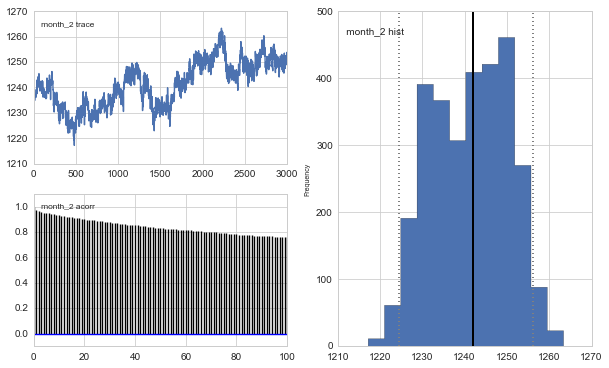

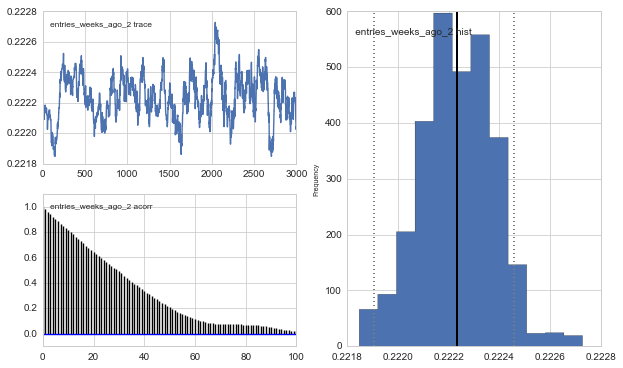

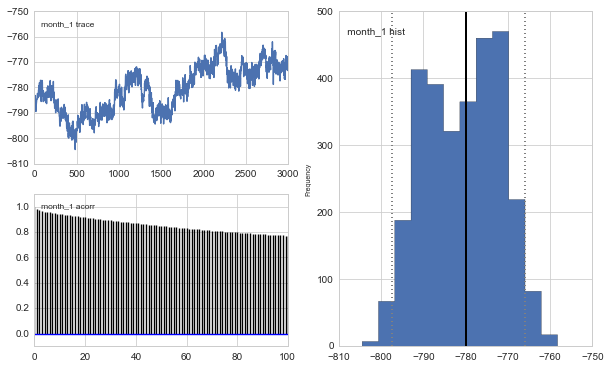

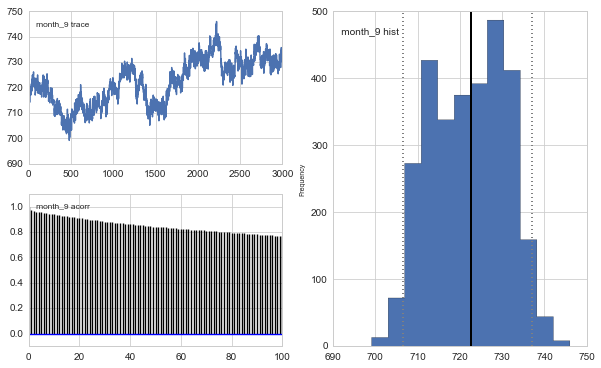

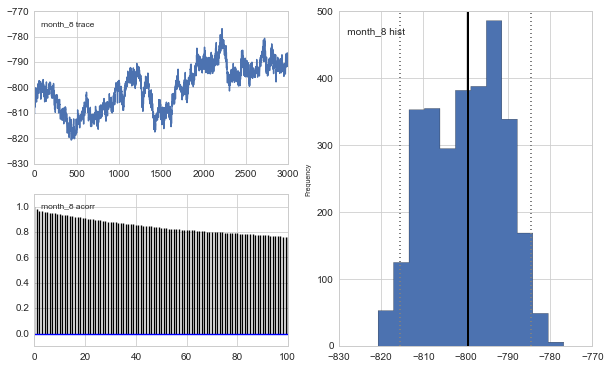

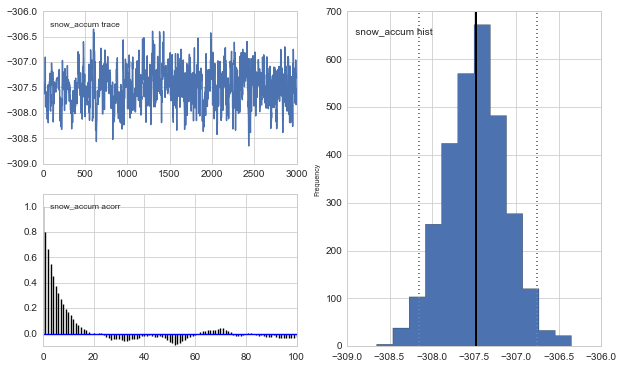

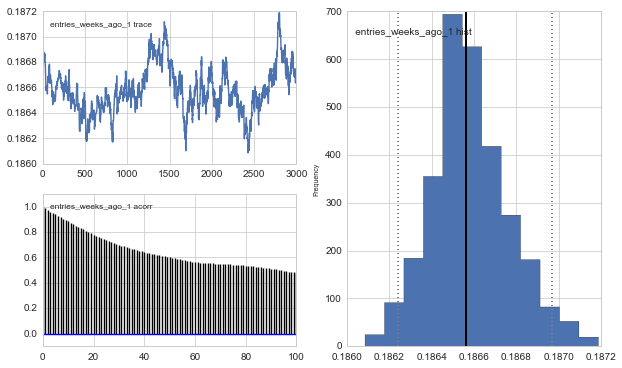

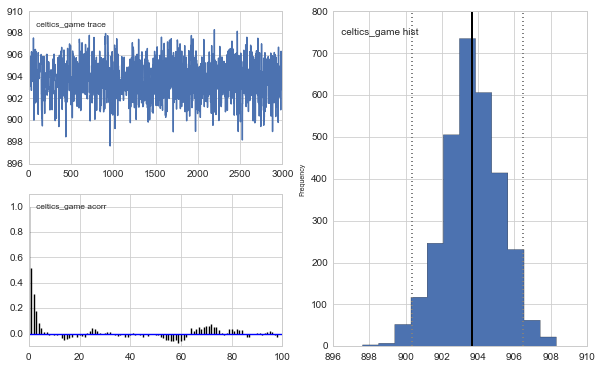

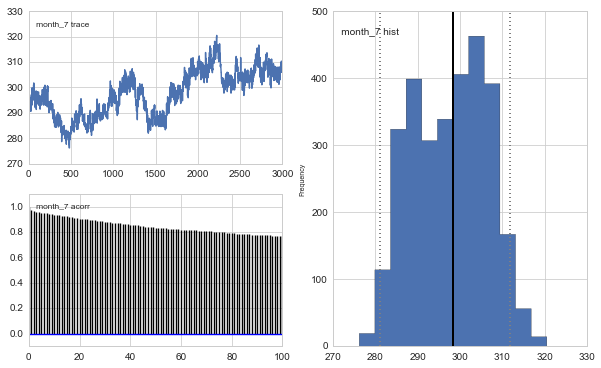

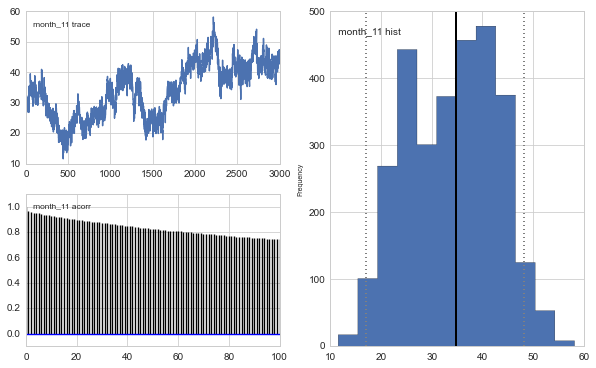

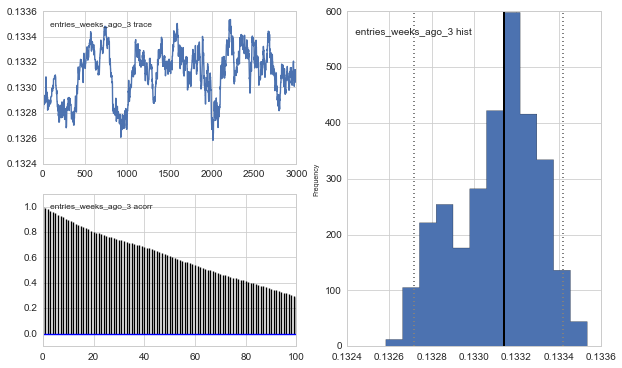

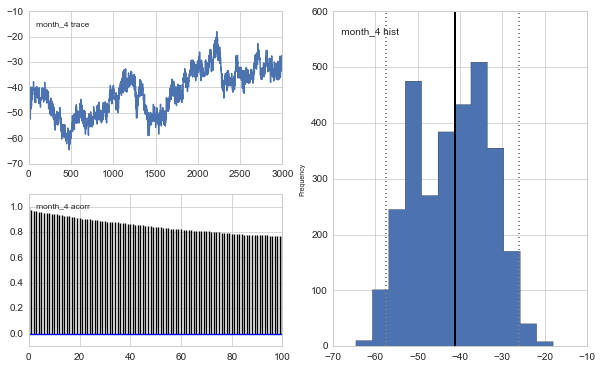

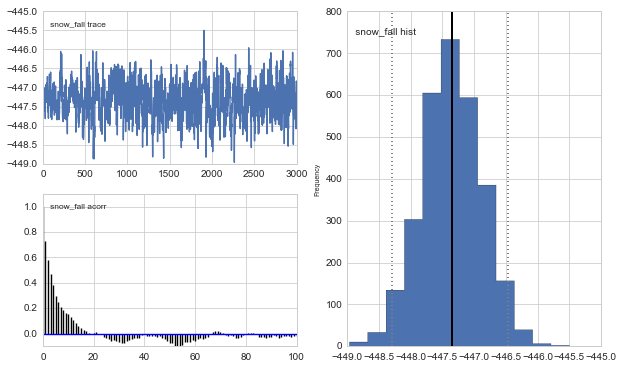

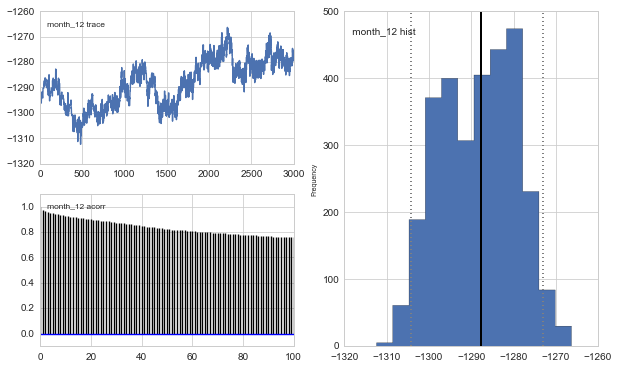

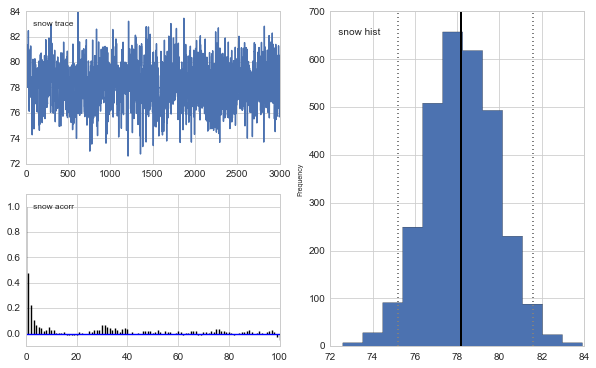

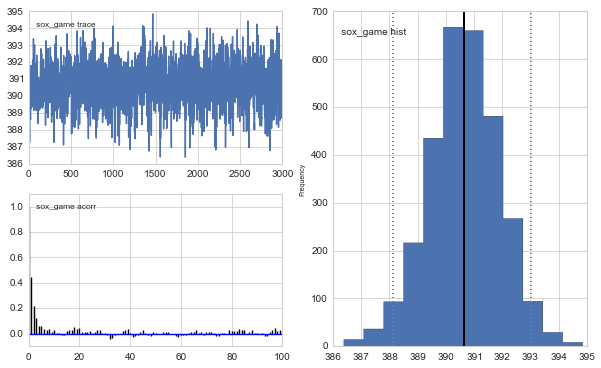

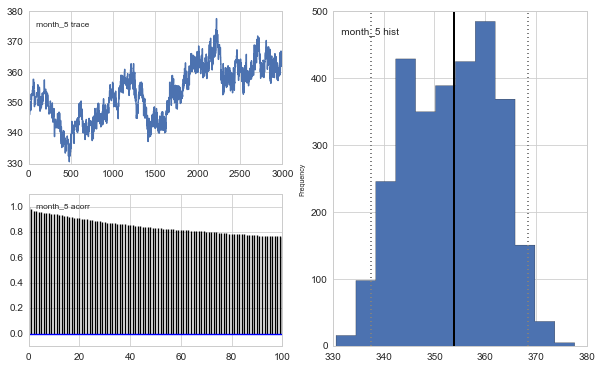

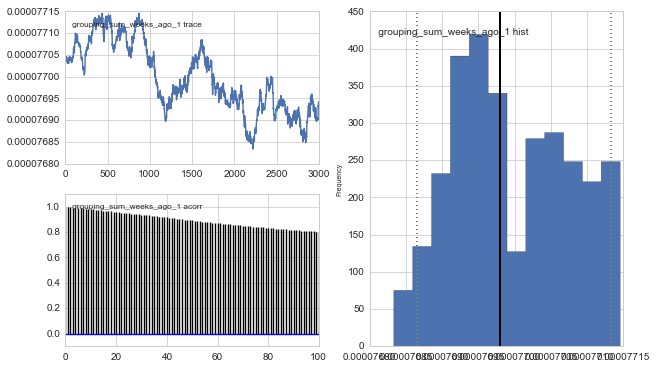

In [49]:
for k, v in coefs.iteritems():
    print(str(k) + ": " + str(v))
pymc.Matplot.plot(mcmc)

### Bayesian Regression on All Stations ###

In [50]:
priors = system_priors(data)
results = pd.DataFrame()

for locationid in np.unique(data.locationid):
    result = pd.Series()
    
    station = data[data['locationid'] == locationid]
    result['locationid'] = locationid
    result['name'] = station['name'].iloc[0]
    
    # Get the observed entries and predictors for this station.
    Y, X = station_data(station)
    
    mcmc, coefs = station_bayesian_regression(priors, Y, X)
    
    # We have to convert the coefficient dictionary into betas that the compare method understands.
    betas = []
    for feature in features:
        betas.append(coefs[feature])
    
    # Run 50 random trials (test sets) of comparing OLS to a regression fit with the betas from MCMC.
    comparisons = []
    for rstate in xrange(50):
        comparisons.append(compare(Y, X, betas, rstate=rstate))
    
    means = np.mean(comparisons, axis=0)
    result['ols'] = means[0]
    result['blr'] = means[1]
    
    # Save the result.
    print(result['name'] + " complete...")
    results = results.append(result, ignore_index=True)

results.to_csv("bayesian-results.csv", ignore_index=True)

 [-----------------100%-----------------] 25000 of 25000 complete in 45.2 secAndrew Square complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 70.8 secJFK/U Mass complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 96.4 secNorth Quincy complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 121.6 secWollaston complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 147.4 secQuincy Center complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 164.9 secSouth Station complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 175.8 secMaverick complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 244.2 secAirport complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 226.8 secAquarium complete...
 [-----------------100%-----------------] 25000 of 25000 complete in 280.3 secWood Island c

### Analysis of Results ###

In [51]:
results = pd.read_csv("bayesian-results.csv", low_memory=False)
results.drop('Unnamed: 0', axis=1, inplace=True)
results['diff'] = results['ols'] - results['blr']
results.head()

,blr,locationid,name,ols,diff
0,0.049159,1002,Andrew Square,0.054312,0.005152
1,0.110969,1004,JFK/U Mass,0.099176,-0.011794
2,0.071587,1005,North Quincy,0.061573,-0.010014
3,0.089805,1006,Wollaston,0.053494,-0.036311
4,0.069901,1007,Quincy Center,0.058591,-0.011310


#### Best and Worst Improvements ####

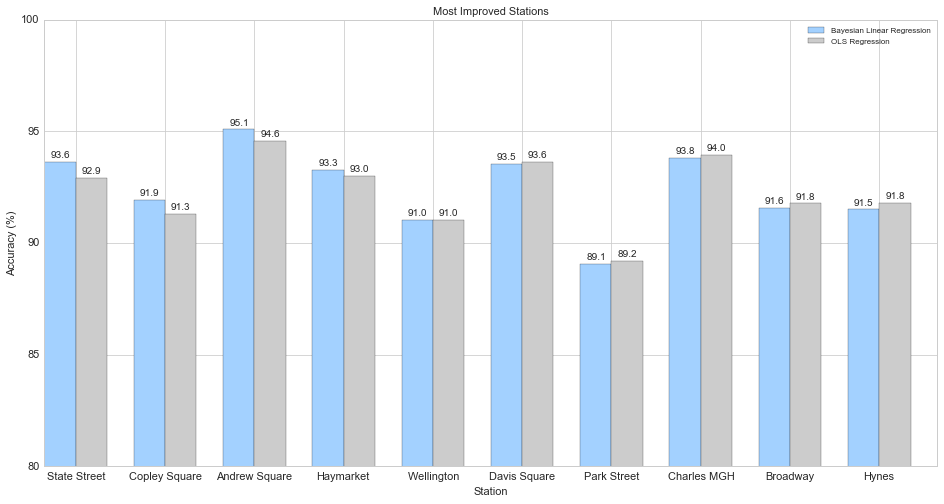

In [52]:
best_results = results.sort('diff', ascending=False)[:10]

n = len(best_results)

names = best_results['name'].values
ols_accuracy = (1.0 - best_results['ols'].values) * 100
blr_accuracy = (1.0 - best_results['blr'].values) * 100

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(ind, blr_accuracy, width, color='#A3D1FF')
rects2 = ax.bar(ind+width, ols_accuracy, width, color='#CCCCCC')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + .1, '%.1f'%height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Most Improved Stations')
ax.set_xlabel('Station')
ax.set_ylabel('Accuracy (%)')

ax.set_xticks(ind+width)
ax.set_xticklabels(names, {'size':'11'})

ax.set_ylim([80, 100])

ax.legend( (rects1[0], rects2[0]), ('Bayesian Linear Regression', 'OLS Regression') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

plt.show()

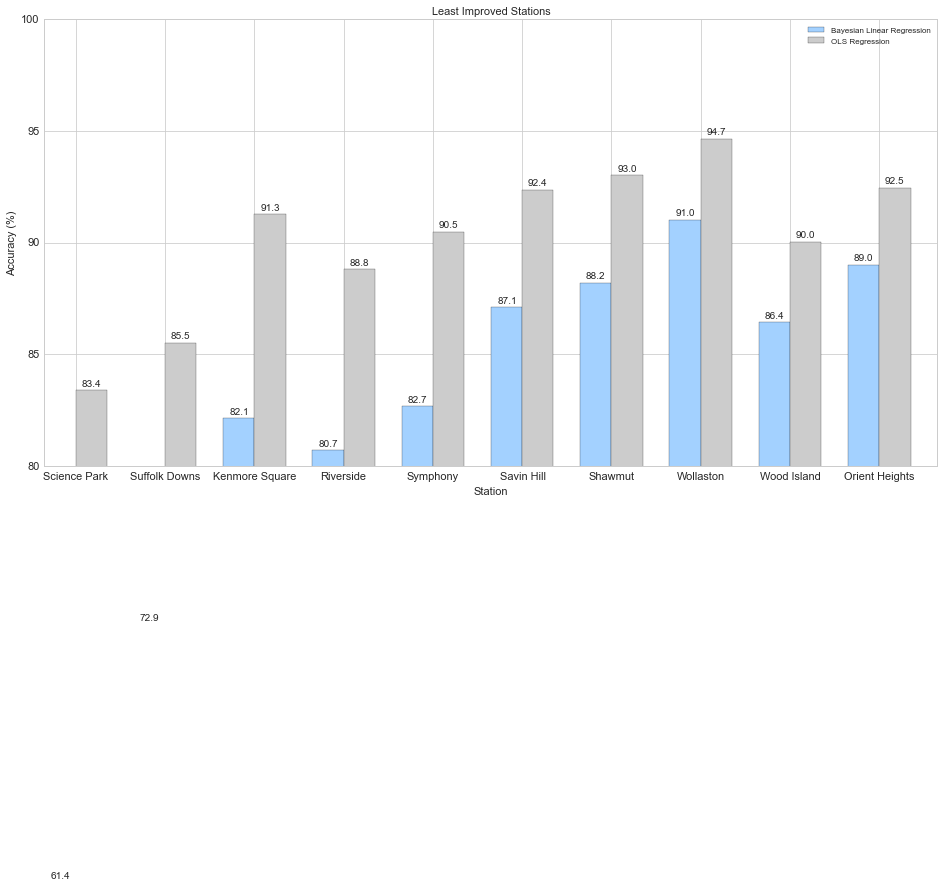

In [53]:
worst_results = results.sort('diff', ascending=True)[:10]

n = len(best_results)

names = worst_results['name'].values
ols_accuracy = (1.0 - worst_results['ols'].values) * 100
blr_accuracy = (1.0 - worst_results['blr'].values) * 100

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(ind, blr_accuracy, width, color='#A3D1FF')
rects2 = ax.bar(ind+width, ols_accuracy, width, color='#CCCCCC')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + .1, '%.1f'%height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Least Improved Stations')
ax.set_xlabel('Station')
ax.set_ylabel('Accuracy (%)')

ax.set_xticks(ind+width)
ax.set_xticklabels(names, {'size':'11'})

ax.set_ylim([80, 100])

ax.legend( (rects1[0], rects2[0]), ('Bayesian Linear Regression', 'OLS Regression') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

plt.show()

#### Overall Results ###
All station predictions improved using the bayesian linear regression versus oridnary least squares. However, overall we only saw a .5% increase in accuracy.

In [99]:
print("Bayesian Linear Regression Accuracy: " + str(100 - round(np.mean(results.blr) * 100, 2)))
print("Ordinary Linear Regression Accuracy: " + str(100 - round(np.mean(results.ols) * 100, 2)))

Bayesian Linear Regression Accuracy: 92.89
Ordinary Linear Regression Accuracy: 92.35


#### Outliers ###
Unfortuantely, a few outliers still exists (> 10% error). Further analysis will have executed on these stations to further increase their prediction accuracy.

In [106]:
results.sort('blr', ascending=False).head(n=10)

,blr,locationid,name,ols,diff
43,0.164728,1074,Community College,0.173942,0.009213
37,0.155837,1060,Science Park,0.166061,0.010224
11,0.135031,1015,Suffolk Downs,0.144900,0.009869
57,0.105949,1101,Riverside,0.111998,0.006049
29,0.101431,1052,Park Street,0.108125,0.006694
35,0.097486,1058,Prudential,0.103610,0.006124
1,0.093073,1004,JFK/U Mass,0.099176,0.006102
9,0.092283,1013,Wood Island,0.099594,0.007311
33,0.088853,1056,Symphony,0.095154,0.006301
52,0.084713,1083,Roxbury Crossing,0.090177,0.005464
